## LSTM (character + word) POS-tag model PyTorch


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
def prepare_sequence(seq, to_ix):
    """Input: takes in a list of words, and a dictionary containing the index of the words
    Output: a tensor containing the indexes of the word"""
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# This is the example training data
training_data = [
    ("the dog happily ate the big apple".split(), ["DET", "NN", "ADV", "V", "DET", "ADJ", "NN"]),
    ("everybody read that good book quietly in the hall".split(), ["NN", "V", "DET", "ADJ", "NN", "ADV", "PRP", "DET", "NN"]),
    ("the old head master sternly scolded the naughty children for \
     being very loud".split(), ["DET", "ADJ", "ADJ", "NN", "ADV", "V", "DET", "ADJ",  "NN", "PRP", "V", "ADJ", "NN"]),
    ("i love you loads".split(), ["PRN", "V", "PRN", "ADV"])
]
#  These are other words which we would like to predict (within sentences) using the model
other_words = ["area", "book", "business", "case", "child", "company", "country", 
               "day", "eye", "fact", "family", "government", "group", "hand", "home", 
               "job", "life", "lot", "man", "money", "month", "mother", "food", "night", 
               "number", "part", "people", "place", "point", "problem", "program", 
               "question", "right", "room", "school", "state", "story", "student", 
               "study", "system", "thing", "time", "water", "way", "week", "woman", 
               "word", "work", "world", "year", "ask", "be", "become", "begin", "can", 
               "come", "do", "find", "get", "go", "have", "hear", "keep", "know", "let", 
               "like", "look", "make", "may", "mean", "might", "move", "play", "put", 
               "run", "say", "see", "seem", "should", "start", "think", "try", "turn", 
               "use", "want", "will", "work", "would", "asked", "was", "became", "began", 
               "can", "come", "do", "did", "found", "got", "went", "had", "heard", "kept", 
               "knew", "let", "liked", "looked", "made", "might", "meant", "might", "moved", 
               "played", "put", "ran", "said", "saw", "seemed", "should", "started", 
               "thought", "tried", "turned", "used", "wanted" "worked", "would", "able", 
               "bad", "best", "better", "big", "black", "certain", "clear", "different", 
               "early", "easy", "economic", "federal", "free", "full", "good", "great", 
               "hard", "high", "human", "important", "international", "large", "late", 
               "little", "local", "long", "low", "major", "military", "national", "new", 
               "old", "only", "other", "political", "possible", "public", "real", "recent", 
               "right", "small", "social", "special", "strong", "sure", "true", "white", 
               "whole", "young", "he", "she", "it", "they", "i", "my", "mine", "your", "his", 
               "her", "father", "mother", "dog", "cat", "cow", "tiger", "a", "about", "all", 
               "also", "and", "as", "at", "be", "because", "but", "by", "can", "come", "could", 
               "day", "do", "even", "find", "first", "for", "from", "get", "give", "go", 
               "have", "he", "her", "here", "him", "his", "how", "I", "if", "in", "into", 
               "it", "its", "just", "know", "like", "look", "make", "man", "many", "me", 
               "more", "my", "new", "no", "not", "now", "of", "on", "one", "only", "or", 
               "other", "our", "out", "people", "say", "see", "she", "so", "some", "take", 
               "tell", "than", "that", "the", "their", "them", "then", "there", "these", 
               "they", "thing", "think", "this", "those", "time", "to", "two", "up", "use", 
               "very", "want", "way", "we", "well", "what", "when", "which", "who", "will", 
               "with", "would", "year", "you", "your","feel","today"]

word_to_ix = {} # This is the word dictionary which will contain the index to each word

for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix.keys():
            word_to_ix[word] = len(word_to_ix)
for word in other_words:
    if word not in word_to_ix.keys():
            word_to_ix[word] = len(word_to_ix)

#print(word_to_ix) # Just have a look at what it contains

tag_to_ix = {"DET": 0, "NN": 1, "V": 2, "ADJ": 3, "ADV": 4, "PRP": 5, "PRN": 6} # This dictionary contains the indices of the tags

EMBEDDING_DIM = 64
HIDDEN_DIM = 64

In [3]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        #print('embed size',embeds.shape,embeds.view(len(sentence), 1, -1).shape)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        #print('lstm_out size',lstm_out.shape,lstm_out.view(len(sentence), 1, -1).shape)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        #print(tag_space.shape)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

Running a check on the model before training.
Sentences:
I feel very good today
she like my dog
[('I', 'ADV'), ('feel', 'ADV'), ('very', 'ADV'), ('good', 'ADV'), ('today', 'ADV')]
[('she', 'V'), ('like', 'ADV'), ('my', 'ADV'), ('dog', 'ADV')]
Training Started
Training Finished!!!
Again testing on unknown data
torch.Size([5, 7])
[('I', 'ADV'), ('feel', 'NN'), ('very', 'ADJ'), ('good', 'ADJ'), ('today', 'ADJ')]
torch.Size([4, 7])
[('she', 'V'), ('like', 'V'), ('my', 'V'), ('dog', 'NN')]


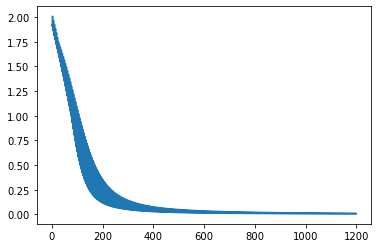

In [4]:
# Here I initialize the model with all the necesarry parameters
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix.keys()), len(tag_to_ix.keys()))

# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

# The test sentence
seq1 = "I feel very good today".split()
seq2 = "she like my dog".split()
print("Running a check on the model before training.\nSentences:\n{}\n{}".format(" ".join(seq1), " ".join(seq2)))
with torch.no_grad():
    for seq in [seq1, seq2]:
        inputs = prepare_sequence(seq, word_to_ix)
        tag_scores = model(inputs)
        _, indices = torch.max(tag_scores, 1)
        ret = []
        for i in range(len(indices)):
            for key, value in tag_to_ix.items():
                if indices[i] == value:
                    ret.append((seq[i], key))
        print(ret)
    
print("Training Started")
totloss=[]
for epoch in range(300):
    for sentence, tags in training_data:
        model.zero_grad()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        
        tag_scores = model(sentence_in)
        
        loss = loss_function(tag_scores, targets)
        totloss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
print("Training Finished!!!\nAgain testing on unknown data")
with torch.no_grad():
    for seq in [seq1, seq2]:
        inputs = prepare_sequence(seq, word_to_ix)
        tag_scores = model(inputs)
        print(tag_scores.shape)
        _, indices = torch.max(tag_scores, 1)
        ret = []
        for i in range(len(indices)):
            for key, value in tag_to_ix.items():
                if indices[i] == value:
                    ret.append((seq[i], key))
        print(ret)
plt.plot(totloss)

# Recommender systems: Matrix factorization

In [21]:
import numpy as np
from scipy.sparse import rand as sprand
import torch
import torch.nn as nn

# Make up some random explicit feedback ratings
# and convert to a numpy array
n_users = 3#1_000
n_items = 3#1_000
ratings = sprand(n_users, n_items, density=0.2, format="csr")
ratings.data = np.random.randint(1, 5, size=ratings.nnz).astype(np.float64)
ratings = ratings.toarray()

ratings2 = sprand(n_users, n_items, density=0.2, format="csr")
ratings2.data = np.random.randint(1, 5, size=ratings2.nnz).astype(np.float64)
ratings2 = ratings2.toarray()



In [32]:
print(ratings)
print()
print(ratings2)

res=np.zeros((len(ratings),len(ratings[0])))

dic={}
dic2={}

#sparse representation of the matrices saved as {(i,j):v} format in a dictionary
for i in range(len(ratings)):
    for j in range (len(ratings[0])):
        if ratings[i][j]!=0:
            dic[(i,j)]=ratings[i][j]
            
        if ratings2[i][j]!=0:
            dic2[(i,j)]=ratings2[i][j]
print(dic)
print(dic2)

for (r1,c1),v in dic.items():
    for (r2,c2),v2 in dic2.items():
        if c1==r2:
            
        
    

[[0. 0. 4.]
 [0. 0. 0.]
 [2. 0. 0.]]

[[0. 0. 0.]
 [0. 4. 0.]
 [0. 4. 0.]]
{(0, 2): 4.0, (2, 0): 2.0}
{(1, 1): 4.0, (2, 1): 4.0}
0 4.0
2 2.0


In [8]:
class matrixFactorization(nn.Module):
    def __init__(self,nUsers,nItems,factor=2):
        super(matrixFactorization,self).__init__()
        self.userEmbedding=nn.Embedding(nUsers,factor,sparse=True)
        self.itemEmbeddings=nn.Embedding(nItems,factor,sparse=True)
    
    def forward(self,user,item):
        return (self.userEmbedding(user)*self.itemEmbeddings(item)).sum(1)
    

In [99]:
model=matrixFactorization(n_users,n_items,2)

loss_func=nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.001)


In [100]:
# Sort our data
rows, cols = ratings.nonzero()
#print(rows,cols)
p = np.random.permutation(len(rows))
#print(p)
rows, cols = rows[p], cols[p]
#print(rows,cols)

In [101]:
losses=[]
for epoch in range(400):
    curloss=0
    step=0
    for row, col in zip(*(rows, cols)):
        step+=1
        # Set gradients to zero
        optimizer.zero_grad()

        # Turn data into tensors
        rating = torch.FloatTensor([ratings[row, col]])
        row = torch.LongTensor([row])
        col = torch.LongTensor([col])

        # Predict and calculate loss
        prediction = model(row, col)

        loss = loss_func(prediction, rating)
        curloss+=loss.item()
    
        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
    losses.append(curloss/step)

[[1. 2. 3. 0. 1. 2. 4. 0. 2. 1.]
 [1. 1. 3. 1. 4. 2. 2. 1. 0. 1.]
 [2. 4. 3. 4. 2. 1. 0. 1. 1. 0.]
 [0. 1. 4. 0. 1. 1. 2. 2. 4. 4.]
 [4. 0. 4. 4. 0. 4. 1. 4. 0. 0.]
 [2. 4. 2. 2. 2. 1. 0. 0. 4. 3.]
 [2. 3. 2. 4. 3. 3. 4. 1. 1. 4.]
 [1. 0. 3. 2. 4. 4. 1. 1. 2. 1.]
 [3. 0. 1. 0. 4. 4. 0. 0. 4. 3.]
 [0. 2. 3. 3. 1. 3. 3. 1. 1. 0.]]


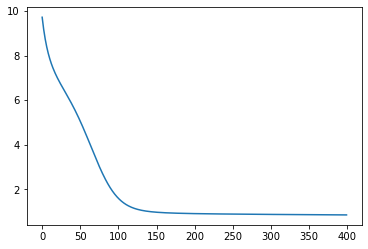

In [102]:
import  matplotlib.pyplot as plt
plt.plot(losses)
print(ratings)

In [104]:

with torch.no_grad():
    pred=model(torch.tensor([9]),torch.tensor([0]))
    print(pred)
    

tensor([2.1273])


In [43]:
import torch
import torch.nn as nn

model=nn.Linear(10,2)

loss_func=nn.MSELoss()

input_vector=torch.randn(10)
prediction=model(input_vector)
Gt=torch.tensor([0,1])
loss=loss_func(prediction,Gt)
print(input_vector,prediction,loss)

tensor([ 1.0214e+00, -2.1773e+00,  2.3675e-01,  2.3117e+00,  5.3566e-04,
         1.3152e-01, -9.7963e-01, -2.6640e+00, -8.2610e-01,  7.4281e-01]) tensor([0.4867, 0.2785], grad_fn=<AddBackward0>) tensor(0.3787, grad_fn=<MseLossBackward0>)


In [49]:
import torch.nn as nn

model=nn.Sequential(nn.Linear(3,5),
                   nn.ReLU(),
                    nn.Linear(5,2),
                    nn.ReLU())

for name,p in model.named_parameters():
    print(name,p)


0.weight Parameter containing:
tensor([[ 0.4861,  0.0571,  0.0342],
        [-0.3225, -0.2848, -0.3806],
        [-0.3647, -0.4927,  0.1789],
        [ 0.2739,  0.0799,  0.3640],
        [-0.3199,  0.1068,  0.2925]], requires_grad=True)
0.bias Parameter containing:
tensor([ 0.5144, -0.0796, -0.1078, -0.2687,  0.2310], requires_grad=True)
2.weight Parameter containing:
tensor([[-0.0592,  0.3128, -0.0380, -0.2007, -0.3311],
        [ 0.3781,  0.4304, -0.2772,  0.0843, -0.2007]], requires_grad=True)
2.bias Parameter containing:
tensor([ 0.2276, -0.3892], requires_grad=True)


# VAE

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.features =16
        # encoder
        self.enc1 = nn.Linear(in_features=3072, out_features=128)
        self.enc2 = nn.Linear(in_features=128, out_features=self.features * 2)

        # decoder
        self.dec1 = nn.Linear(in_features=self.features, out_features=128)
        self.dec2 = nn.Linear(in_features=128, out_features=3072)

    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, self.features)
        # get `mu` and `log_var`
        mu = x[:, 0, :]  # the first feature values as mean
        log_var = x[:, 1, :]  # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var)  # standard deviation
        eps = torch.randn_like(std)  # generate sample of the same size
        sample = mu + (eps * std)  # sampling as if coming from the input space
        return sample

In [46]:

    
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [47]:
import os
import sys
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim

cwd = os.getcwd()
#add CIFAR10 data in the environment
sys.path.append(cwd + '/../cifar10') 
batch_size=1


def load_data():
    
    #convert the images to tensor and normalized them
    transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    trainset =torchvision.datasets.CIFAR10(root='../cifar10',  transform=transform,download=True)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=1)
    return trainloader

In [61]:
def train(model,training_data):

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss(reduction='sum')

    running_loss = 0.0

    for epoch in range(1):  # loop over the dataset multiple times

        for i, data in enumerate(training_data, 0):
            inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()
            reconstruction, mu, logvar = model(inputs)
            bce_loss = criterion(reconstruction, inputs)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    PATH = './cifar_net.pth'
    torch.save(model.state_dict(), PATH)

    print('Finished Training')

In [62]:
trainloader=load_data()

Files already downloaded and verified


torch.Size([1, 3, 32, 32])


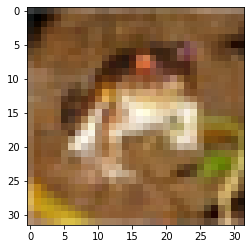

frog 


In [63]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [64]:
model=VAE()
train(model,trainloader)

[1,  2000] loss: -56146.893
[1,  4000] loss: -70058.395
[1,  6000] loss: -71362.277
[1,  8000] loss: -73500.338
[1, 10000] loss: -75543.142
[1, 12000] loss: -77074.568
[1, 14000] loss: 334371.502
[1, 16000] loss: -85417.860
[1, 18000] loss: 369923.860
[1, 20000] loss: -85576.387
[1, 22000] loss: -86491.117
[1, 24000] loss: -89407.634
[1, 26000] loss: -86181.065
[1, 28000] loss: -86359.170
[1, 30000] loss: -86678.511
[1, 32000] loss: -85929.360
[1, 34000] loss: -88740.907
[1, 36000] loss: -78596.492
[1, 38000] loss: -88964.447
[1, 40000] loss: -85810.345
[1, 42000] loss: -87533.843
[1, 44000] loss: -84829.239
[1, 46000] loss: 112777.788
[1, 48000] loss: -55955.773
[1, 50000] loss: -71999.764
Finished Training


Epoch0, loss : 0.6972151398658752
Epoch5, loss : 0.69350665807724
Epoch10, loss : 0.692272961139679
Epoch15, loss : 0.6893554925918579


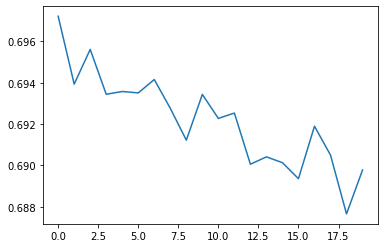

In [73]:


#get_ipython().run_line_magic('matplotlib', 'inline')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


# In[2]:


class RankNet(nn.Module):
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear( num_feature, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
#             nn.Sigmoid()
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1,input_2):


        s1 = self.model(input_1)
        s2 = self.model(input_2)
        
        out = self.output_sig(s1-s2)

        return out
    
    def predict(self, input_):
        
        s = self.model(input_)
        return s


# In[12]:


n_sample = 3000
n_feature = 30
data1 = torch.rand((n_sample,n_feature))
data2 = torch.rand((n_sample, n_feature))

y = np.random.random(( n_sample,1))
y = y > 0.9
y = 1. * y
y = torch.Tensor(y)

rank_model = RankNet(num_feature=n_feature)
optimizer = torch.optim.Adam(rank_model.parameters())

loss_fun = torch.nn.BCELoss()

#rank_model.cuda()
# optimizer.cuda()
#loss_fun.cuda()

#data1 = data1.cuda()
#data2 = data2.cuda()

#y = y.cuda()


# In[13]:


epoch = 20

losses = []

for i in range(epoch):
    
    rank_model.zero_grad()
    
    y_pred = rank_model(data1, data2)
    
    loss = loss_fun(y_pred,y)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if i % 5 == 0:
    
        print('Epoch{}, loss : {}'.format(i, loss.item()))
    
    


# In[6]:


import matplotlib.pyplot as plt


# In[7]:


#x = list(range(10000))


# In[11]:


plt.plot( losses)

# Weighted loss for imbalanced data

In [13]:
import torch
import torch.nn as nn

# Define the loss function, in this case, binary cross-entropy
criterion = nn.BCELoss(reduction='mean')

# Define the target and predicted outputs
target = torch.tensor([0, 1, 0, 0], dtype=torch.float32)
predicted = torch.tensor([0.1, 0.4, 0.8, 0.2], dtype=torch.float32)

# Calculate the class weights based on the frequency of the classes
class_weights = torch.tensor([1/(len(target[target==0])),1/len(target[target==1])], dtype=torch.float32)

# Calculate the weighted loss
loss = criterion(predicted, target)
weighted_loss = (class_weights[target.long()] * loss).mean()

print('target:',target)
print('class weights',class_weights)
print('class weights of target:',class_weights[target.long()])
print(loss)
print(weighted_loss)


target: tensor([0., 1., 0., 0.])
class weights tensor([0.3333, 1.0000])
class weights of target: tensor([0.3333, 1.0000, 0.3333, 0.3333])
tensor(0.7136)
tensor(0.3568)


In [5]:
# Calculate the frequency of each class
class_counts = torch.bincount(target.to(dtype=torch.uint8))

# Calculate the inverse of the frequency to get the class weights
class_weights = 1. / class_counts

print(class_counts)
print(class_weights)

tensor([3, 1])
tensor([0.3333, 1.0000])


# Seq to Seq model for language translation

In [87]:
import nltk
#nltk.download('punkt')

# Example input and output sequences
input_lang = [
    'hello there', 'goodbye for now', 'thanks', 'yes', 'no', 'please',
    'what is your name', 'how are you', 'i am good', 'can you help me',
    'where are you', 'when is your birthday', 'i love you', 'you are beautiful',
    'i miss you', 'how old are you', 'what do you like', 'what is the time',
    'how much does it cost', 'what are you doing', 'how was your day',
    'i am sorry', 'what is your job', 'what are you', 'what is your favorite color',
    'what is your favorite food', 'what is your hobby', 'what do you want to do',
    'what is your country', 'where do you live', 'what is your age', 'what is your phone number',
    'what do you think', 'what is your favorite book', 'what is your favorite movie', 'what is your favorite music',
    'what is your dream', 'what is your plan', 'what is your goal', 'what is your religion',
    'what is your email', 'what is your website', 'what is your company', 'what is your education',
    'what is your experience', 'what is your address', 'what is your personality', 'what is your attitude',
    'what is your skill', 'what is your strength', 'what is your weakness', 'what is your challenge',
    'what is your achievement', 'what is your interest', 'what is your favorite sport', 'what is your favorite hobby',
    'what is your favorite place', 'what is your favorite animal', 'what is your favorite subject', 'what is your favorite job',
    'what is your favorite character', 'what is your favorite quote', 'what is your favorite game', 'what is your favorite website',
    'what is your favorite drink', 'what is your favorite season', 'what is your favorite holiday', 'what is your favorite restaurant',
    'what is your favorite song', 'what is your favorite singer', 'what is your favorite actor', 'what is your favorite actress',
    'what is your favorite musician', 'what is your favorite band', 'what is your favorite artist', 'what is your favorite designer',
    'what is your favorite brand', 'what is your favorite car', 'what is your favorite color', 'what is your favorite flower',
    'what is your favorite tree', 'what is your favorite fruit', 'what is your favorite vegetable', 'what is your favorite animal',
    'what is your favorite bird', 'what is your favorite insect', 'what is your favorite fish', 'what is your favorite ocean',
    'what is your favorite mountain', 'what is your favorite river', 'what is your favorite lake', 'what is your favorite city',
    'what is your favorite country', 'what is your favorite continent', 'what is your favorite planet', 'what is your favorite galaxy',
    'what is your favorite universe', 'what is your favorite language', 'what is your favorite word', 'what is your favorite letter'
]

output_lang = [
    'Merhaba', 'Şimdilik hoşça kal', 'Teşekkürler', 'Evet', 'Hayır', 'Lütfen',
    'Adın ne', 'Nasılsın', 'Ben iyiyim', 'Bana yardım edebilir misin',
    'Neredesin', 'Doğum günün ne zaman', 'Seni seviyorum', 'Sen çok güzelsin',
    'Seni özledim', 'Kaç yaşındasın', 'Ne yapmaktan hoşlanırsın', 'Saat kaç',
    'Ne kadar tutar', 'Ne yapıyorsun', 'Günün nasıldı',
    'Üzgünüm', 'Mesleğin ne', 'Sen kimsin', 'En sevdiğin renk nedir',
    'En sevdiğin yemek nedir', 'Hobin nedir', 'Ne yapmak istersin',
    'Hangi ülkedesin', 'Nerede yaşıyorsun', 'Kaç yaşındasın', 'Telefon numaran nedir',
    'Ne düşünüyorsun', 'En sevdiğin kitap nedir', 'En sevdiğin film nedir', 'En sevdiğin müzik nedir',
    'Hayalın ne', 'Planın ne', 'Hedefin ne', 'Dinin ne',
    'E-posta adresin nedir', 'Web siten nedir', 'Şirketin nedir', 'Eğitimin ne',
    'Deneyimin nedir', 'Adresin nedir', 'Kişiliğin ne', 'Tutumun ne',
    'Hangi becerilere sahipsin', 'Hangi güçlü yönlerin var', 'Hangi zayıf yönlerin var', 'Hangi zorluklarla karşılaşıyorsun',
    'Hangi başarılarına gurur duyuyorsun', 'Hangi konular seni ilgilendiriyor', 'En sevdiğin spor nedir', 'En sevdiğin hobi nedir',
    'En sevdiğin yer nedir', 'En sevdiğin hayvan nedir', 'En sevdiğin ders nedir', 'En sevdiğin iş nedir',
    'En sevdiğin karakter kimdir', 'En sevdiğin alıntı nedir', 'En sevdiğin oyun nedir', 'En sevdiğin web sitesi nedir',
    'En sevdiğin içecek nedir', 'En sevdiğin mevsim nedir', 'En sevdiğin tatil nedir', 'En sevdiğin restoran nedir',
    'En sevdiğin şarkı nedir', 'En sevdiğin şarkıcı kim', 'En sevdiğin aktör kimdir', 'En sevdiğin aktris kimdir',
    'En sevdiğin müzisyen kimdir', 'En sevdiğin grup hangisi', 'En sevdiğin sanatçı kim', 'En sevdiğin tasarımcı kim',
    'En sevdiğin marka nedir', 'En sevdiğin araba nedir', 'En sevdiğin renk nedir', 'En sevdiğin çiçek nedir', 
    'En sevdiğin ağaç nedir', 'En sevdiğin meyve nedir', 'En sevdiğin sebze nedir', 'En sevdiğin hayvan nedir', 
    'En sevdiğin kuş nedir', 'En sevdiğin böcek nedir', 'En sevdiğin balık nedir', 'En sevdiğin okyanus nedir', 
    'En sevdiğin dağ nedir', 'En sevdiğin nehir nedir', 'En sevdiğin göl nedir', 'En sevdiğin şehir nedir', 
    'En sevdiğin ülke nedir', 'En sevdiğin kıta nedir', 'En sevdiğin gezegen nedir', 'En sevdiğin galaksi nedir', 
    'En sevdiğin evren nedir', 'En sevdiğin dil nedir', 'En sevdiğin kelime nedir', 'En sevdiğin harf nedir']

print(len(input_lang),len(output_lang))


100 100


In [88]:
# Tokenize the input and output sequences into words
input_words = [nltk.word_tokenize(seq.lower()) for seq in input_lang]
output_words = [nltk.word_tokenize(seq.lower()) for seq in output_lang]

#print(input_words)

# Define a dictionary to map words to indices and vice versa
input_word_to_idx = {word: i for i, word in enumerate(set([word for seq in input_words for word in seq]))}
input_idx_to_word = {i: word for word, i in input_word_to_idx.items()}

output_word_to_idx = {word: i for i, word in enumerate(set([word for seq in output_words for word in seq]))}
output_idx_to_word = {i: word for word, i in output_word_to_idx.items()}

print(input_word_to_idx,len(input_word_to_idx))

print(output_word_to_idx,len(output_word_to_idx))

{'city': 0, 'drink': 1, 'are': 2, 'can': 3, 'day': 4, 'me': 5, 'personality': 6, 'galaxy': 7, 'weakness': 8, 'when': 9, 'to': 10, 'character': 11, 'artist': 12, 'singer': 13, 'designer': 14, 'it': 15, 'word': 16, 'number': 17, 'the': 18, 'achievement': 19, 'quote': 20, 'now': 21, 'tree': 22, 'insect': 23, 'food': 24, 'interest': 25, 'name': 26, 'company': 27, 'musician': 28, 'doing': 29, 'actress': 30, 'game': 31, 'ocean': 32, 'what': 33, 'universe': 34, 'attitude': 35, 'hobby': 36, 'experience': 37, 'letter': 38, 'fish': 39, 'animal': 40, 'phone': 41, 'dream': 42, 'strength': 43, 'job': 44, 'country': 45, 'do': 46, 'continent': 47, 'planet': 48, 'for': 49, 'is': 50, 'fruit': 51, 'subject': 52, 'sorry': 53, 'does': 54, 'place': 55, 'thanks': 56, 'old': 57, 'much': 58, 'live': 59, 'season': 60, 'hello': 61, 'mountain': 62, 'restaurant': 63, 'there': 64, 'please': 65, 'like': 66, 'religion': 67, 'car': 68, 'i': 69, 'where': 70, 'holiday': 71, 'song': 72, 'love': 73, 'plan': 74, 'cost': 7

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device='cpu'
MAX_LENGTH=10

# Define the input and output languages
#input_lang = ['I am', 'You are', 'He is', 'She is', 'We are', 'They are', 'This is', 'That is', 'It is', 'The cat is black', 'The dog is brown']
#output_lang = ['Ben', 'Sen', 'O', 'O', 'Biz', 'Onlar', 'Bu', 'Şu', 'O', 'Kedi siyahdır', 'Köpek kahverengidir']

# Define a dictionary to map words to indices and vice versa
#word_to_idx = {word: i for i, word in enumerate(set(input_lang + output_lang))}
#idx_to_word = {i: word for i, word in enumerate(set(input_lang + output_lang))}

# Define the function to convert a sentence to a tensor of word indices
def sentence_to_tensor(sentence, word_to_idx, device):
    tensor = torch.tensor([word_to_idx[word.lower()] for word in sentence.split()], dtype=torch.long, device=device).view(-1, 1)
    return tensor


pairs = list(zip(input_lang, output_lang))
vocab = set()
# Build vocabulary
for pair in pairs:
    vocab.update(pair[0].split())
    vocab.update(pair[1].split())



# Create word to index and index to word mappings
word_to_idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
idx_to_word = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}


for word in vocab:
    if word not in word_to_idx:
        idx = len(word_to_idx)
        word_to_idx[word] = idx
        idx_to_word[idx] = word

# Define the dataset
dataset = []
for input_sent, target_sent in pairs:
    print(input_sent,'-->',target_sent)
    
    # Convert sentences to numerical tensors
    input_tensor = torch.tensor([word_to_idx.get(word, word_to_idx['<UNK>']) for word in input_sent.split()],dtype=torch.long, device=device)
    output_tensor = torch.tensor([word_to_idx['<SOS>']] + [word_to_idx.get(word, word_to_idx['<UNK>']) for word in target_sent.split()] + [word_to_idx['<EOS>']],dtype=torch.long, device=device)
    dataset.append((input_tensor, output_tensor))
    
print(dataset)

# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))

# Define the Decoder class
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device),
                torch.zeros(self.num_layers, 1, self.hidden_size, device=device))
    


hello there --> Merhaba
goodbye for now --> Şimdilik hoşça kal
thanks --> Teşekkürler
yes --> Evet
no --> Hayır
please --> Lütfen
what is your name --> Adın ne
how are you --> Nasılsın
i am good --> Ben iyiyim
can you help me --> Bana yardım edebilir misin
where are you --> Neredesin
when is your birthday --> Doğum günün ne zaman
i love you --> Seni seviyorum
you are beautiful --> Sen çok güzelsin
i miss you --> Seni özledim
how old are you --> Kaç yaşındasın
what do you like --> Ne yapmaktan hoşlanırsın
what is the time --> Saat kaç
how much does it cost --> Ne kadar tutar
what are you doing --> Ne yapıyorsun
how was your day --> Günün nasıldı
i am sorry --> Üzgünüm
what is your job --> Mesleğin ne
what are you --> Sen kimsin
what is your favorite color --> En sevdiğin renk nedir
what is your favorite food --> En sevdiğin yemek nedir
what is your hobby --> Hobin nedir
what do you want to do --> Ne yapmak istersin
what is your country --> Hangi ülkedesin
where do you live --> Nerede ya

In [90]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    #print(input_tensor.shape)

    input_length = input_tensor.size(0)
    #print(input_length,input_tensor.shape)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[word_to_idx['<SOS>']]], device=device)

    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [101]:
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
import random
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
learning_rate=0.01

encoder=Encoder(len(word_to_idx),512)
decoder=Decoder(512,len(word_to_idx))#change it to Decoder do diable attention
loss=[]
# Define optimizer
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
for epoch in range(20):
    for i_tensor,o_tensor in dataset:
        loss.append(train(i_tensor.unsqueeze(1),o_tensor.unsqueeze(1),encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,7))
    
    
    

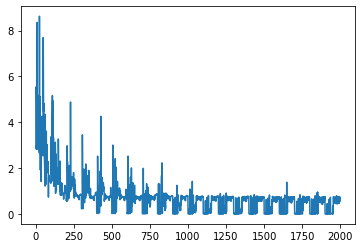

In [104]:
import matplotlib.pyplot as plt
plt.plot(loss)
#512

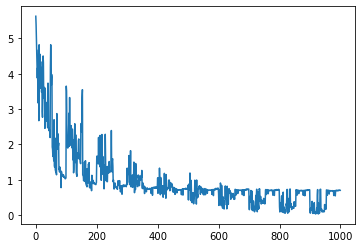

In [6]:
import matplotlib.pyplot as plt
plt.plot(loss)
#512

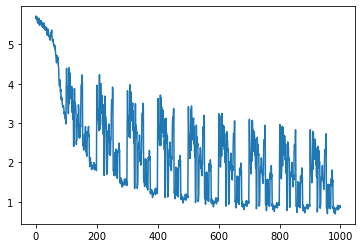

In [7]:
import matplotlib.pyplot as plt
plt.plot(loss)

#32

# Evaluate

In [112]:

# Define the input sequence
input_seq = 'you'
input_seq='<SOS> '+input_seq+' <EOS>'
print(input_seq)
input_seq=[word_to_idx.get(word, word_to_idx['<UNK>']) for word in input_seq.split()]
#print(input_seq)

# Convert the input sequence to a tensor
input_tensor = torch.tensor(input_seq, dtype=torch.long, device=device).unsqueeze(1)#.view(-1, 1)
input_length = input_tensor.size(0)

#print(input_tensor,input_tensor.shape)

# Initialize the encoder hidden state
encoder_hidden = encoder.init_hidden()
#print(len(encoder_hidden))

# Encode the input sequence
#encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]


# Initialize the decoder input with the SOS token
decoder_input = torch.tensor([[word_to_idx['<SOS>']]], device=device)


# Initialize the decoder hidden state with the encoder final hidden state
decoder_hidden = encoder_hidden

# Initialize the output sequence with the SOS token
output_seq = ['<SOS>']

# Decode the input sequence
for i in range(max_length):
    # Decode the current timestep
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    
    # Get the predicted token for the current timestep
    topv, topi = decoder_output.topk(1)
    predicted_token = topi.item()
    
    # Add the predicted token to the output sequence
    output_seq.append(predicted_token)
    #print(predicted_token,word_to_idx['<EOS>'])
    
    # If the predicted token is the EOS token, stop decoding
    if predicted_token == word_to_idx['<EOS>']:#EOS_token:
        break
    
    # Set the decoder input to the predicted token for the next timestep
    decoder_input = torch.tensor([[predicted_token]], device=device)
    
# Convert the output sequence to a list
output_seq = list(output_seq)

# Print the output sequence
#print(output_seq)

out_seq_decoded=[idx_to_word.get(idx, word_to_idx['<UNK>']) for idx in output_seq]

print(out_seq_decoded)

<SOS> you <EOS>
[3, '<SOS>', 'Ne', 'yapmaktan', 'hoşlanırsın', '<EOS>']


# Gradient Decent

Iteration 1: Cost 2357.2785054562255, Weight 		0.9249441700609777, Bias 0.3031073528723089
Iteration 2: Cost 638.2807644057887, Weight 		1.159786222163162, Bias 0.30769094318293416
Iteration 3: Cost 227.58453047716594, Weight 		1.2745748598231263, Bias 0.30992692485869333
Iteration 4: Cost 129.46258808922533, Weight 		1.3306825357092669, Bias 0.3110154178873793
Iteration 5: Cost 106.01967587920187, Weight 		1.3581075182232605, Bias 0.3115430294509235
Iteration 6: Cost 100.41878618749463, Weight 		1.3715126743025154, Bias 0.31179648753435535
Iteration 7: Cost 99.08064290245572, Weight 		1.3780650731906723, Bias 0.31191594203684303
Iteration 8: Cost 98.7609383571383, Weight 		1.3812679098469713, Bias 0.311969896889856
Iteration 9: Cost 98.68455522192394, Weight 		1.3828335124916729, Bias 0.31199183616048687
Iteration 10: Cost 98.66630548866057, Weight 		1.3835988507961812, Bias 0.3119981265407635
Iteration 11: Cost 98.66194476098012, Weight 		1.3839730275379674, Bias 0.3119967679133522
I

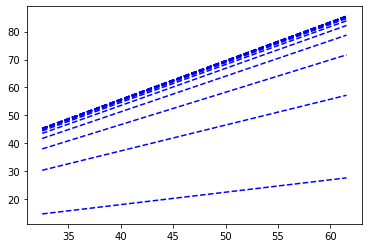

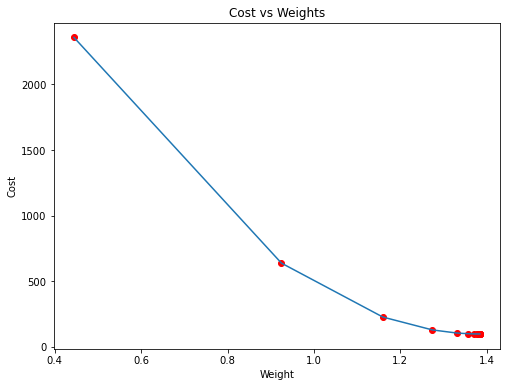

Estimated Weight: 1.3843267732256201
Estimated Bias: 0.31195163289087785


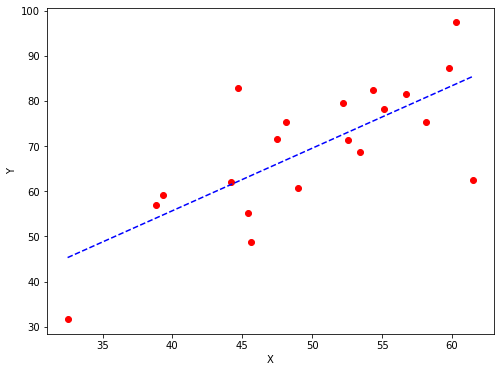

In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt

def mean_squared_error(y_true, y_predicted):
	
	# Calculating the loss or cost
	cost = np.sum((y_true-y_predicted)**2) / len(y_true)
	return cost

# Gradient Descent Function
# Here iterations, learning_rate, stopping_threshold
# are hyperparameters that can be tuned
def gradient_descent(x, y, iterations = 10, learning_rate = 0.0001,
					stopping_threshold = 1e-6):
	
	# Initializing weight, bias, learning rate and iterations
	current_weight = np.random.random()#0.1
	current_bias = np.random.random()#0.01
	iterations = iterations
	learning_rate = learning_rate
	n = float(len(x))
	
	costs = []
	weights = []
	previous_cost = None
	
	# Estimation of optimal parameters
	for i in range(iterations):
		
		# Making predictions
		y_predicted = (current_weight * x) + current_bias
		plt.plot([min(x), max(x)], [min(y_predicted), max(y_predicted)], color='blue',markerfacecolor='red',
        markersize=10,linestyle='dashed')
		
		# Calculating the current cost
		current_cost = mean_squared_error(y, y_predicted)

		# If the change in cost is less than or equal to
		# stopping_threshold we stop the gradient descent
		if previous_cost and abs(previous_cost-current_cost)<=stopping_threshold:
			break
		
		previous_cost = current_cost

		costs.append(current_cost)
		weights.append(current_weight)
		
		# Calculating the gradients
		weight_derivative = -(2/n) * sum(x * (y-y_predicted))
		bias_derivative = -(2/n) * sum(y-y_predicted)
		
		# Updating weights and bias
		current_weight = current_weight - (learning_rate * weight_derivative)
		current_bias = current_bias - (learning_rate * bias_derivative)
				
		# Printing the parameters for each 1000th iteration
		print(f"Iteration {i+1}: Cost {current_cost}, Weight \
		{current_weight}, Bias {current_bias}")
	
	
	# Visualizing the weights and cost at for all iterations
	plt.figure(figsize = (8,6))
	plt.plot(weights, costs)
	plt.scatter(weights, costs, marker='o', color='red')
	plt.title("Cost vs Weights")
	plt.ylabel("Cost")
	plt.xlabel("Weight")
	plt.show()
	
	return current_weight, current_bias


def main():
	
	# Data
	X = np.array([32.50234527, 53.42680403, 61.53035803, 47.47563963, 59.81320787,
		55.14218841, 52.21179669, 39.29956669, 48.10504169, 52.55001444,
		45.41973014, 54.35163488, 44.1640495 , 58.16847072, 56.72720806,
		48.95588857, 44.68719623, 60.29732685, 45.61864377, 38.81681754])
	Y = np.array([31.70700585, 68.77759598, 62.5623823 , 71.54663223, 87.23092513,
		78.21151827, 79.64197305, 59.17148932, 75.3312423 , 71.30087989,
		55.16567715, 82.47884676, 62.00892325, 75.39287043, 81.43619216,
		60.72360244, 82.89250373, 97.37989686, 48.84715332, 56.87721319])

	# Estimating weight and bias using gradient descent
	estimated_weight, estimated_bias = gradient_descent(X, Y, iterations=100)
	print(f"Estimated Weight: {estimated_weight}\nEstimated Bias: {estimated_bias}")

	# Making predictions using estimated parameters
	Y_pred = estimated_weight*X + estimated_bias

	# Plotting the regression line
	plt.figure(figsize = (8,6))
	plt.scatter(X, Y, marker='o', color='red')
	plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='blue',markerfacecolor='red',
			markersize=10,linestyle='dashed')
	plt.xlabel("X")
	plt.ylabel("Y")
	plt.show()

	
if __name__=="__main__":
	main()


In [117]:
np.random.random()

0.6594516358241309

## Sentence Embedding with BERT

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


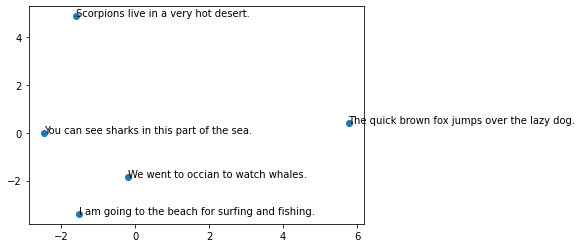

In [18]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define a function to generate sentence embeddings
def generate_sentence_embedding(sentence):
    # Tokenize the input sentence and convert it to token IDs
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True)])
    # Generate the BERT embeddings for the input sentence
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs.last_hidden_state
    # Average the last hidden states to obtain the sentence embedding
    sentence_embedding = torch.mean(last_hidden_states, dim=1)
    return sentence_embedding.numpy()

# Define some sample sentences
sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "I am going to the beach for surfing and fishing.",
    "We went to occian to watch whales.",
    "You can see sharks in this part of the sea.",
    "Scorpions live in a very hot desert."
]

# Generate sentence embeddings for the sample sentences
sentence_embeddings = [generate_sentence_embedding(sent) for sent in sentences]

# Remove the batch dimension from the sentence embeddings
sentence_embeddings = [embedding[0] for embedding in sentence_embeddings]


# Perform PCA on the sentence embeddings to reduce their dimensionality to 2
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Visualize the reduced embeddings in a 2D scatter plot
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
for i, sent in enumerate(sentences):
    plt.annotate(sent, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.show()
